In [2]:
import json
import pandas as pd
import os

df = pd.DataFrame()
for dirname, _, filenames in os.walk('../data/100/'):
    for filename in filenames:
        data = {}
        with open(os.path.join(dirname, filename),'r') as file:
            d = json.loads(file.read())
        data['date'] = d['Indices']['NDVI']['Serie Processada']['Data']
        data['indices'] = d['Indices']['NDVI']['Serie Processada']['Indice']
        part = pd.DataFrame(data)
        part['date'] = pd.to_datetime(part['date'], format='%Y-%m-%d')
        print(os.path.join(dirname, filename))
        df = pd.concat([df, part])
df.head(10)

../data/100/2014-2015.json
../data/100/2016-2017.json
../data/100/2018-2019.json
../data/100/2015-2016.json
../data/100/2017-2018.json


,date,indices
0,2014-07-04,0.565087
1,2014-07-12,0.577556
2,2014-07-20,0.570085
3,2014-07-28,0.525197
4,2014-08-05,0.479784
5,2014-08-13,0.462151
6,2014-08-21,0.474681
7,2014-08-29,0.500842
8,2014-09-06,0.520316
9,2014-09-14,0.521451


In [3]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.set_index('date')
df = df.groupby(df.index).mean()
df = df.asfreq("W",method='backfill')
df = df.sort_index()
df.head(10)

,indices
date,
2014-07-06,0.577556
2014-07-13,0.570085
2014-07-20,0.570085
2014-07-27,0.525197
2014-08-03,0.479784
2014-08-10,0.462151
2014-08-17,0.474681
2014-08-24,0.500842
2014-08-31,0.520316


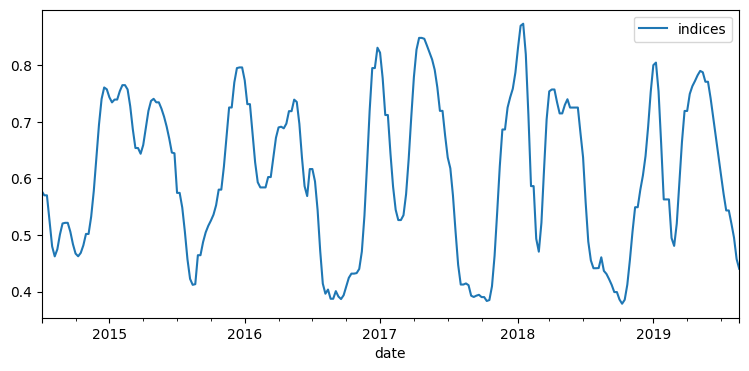

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(9, 4))
df['indices'].plot(ax=ax, label='indices')
ax.legend()

In [5]:
from datetime import datetime

steps=10
X_train = df.loc[:datetime.strptime('2019-02-28', "%Y-%m-%d")]
X_test = df.loc[datetime.strptime('2019-02-28', "%Y-%m-%d"):datetime.strptime('2019-05-30', "%Y-%m-%d")]

In [6]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
auto = auto_arima(
    X_train['indices'],
    seasonal=True,
    stationary=True,
    trace=True, 
    error_action='ignore', 
    suppress_warnings=True
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-1092.883, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-273.115, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-914.192, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-563.068, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=458.588, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-1065.369, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-1094.363, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-1023.326, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-1096.157, Time=0.15 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-1094.382, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-1092.689, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-1070.659, Time=0.04 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 1.365 seconds


In [7]:
sarima = SARIMAX(X_train['indices'],order=auto.order,seasonal_order=(4,1,2,8),freq='W',enforce_stationarity=True)
model = sarima.fit()

/home/pedro/workspace/POP-backend/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.00037D+00    |proj g|=  6.96926D+00

At iterate    5    f= -2.05814D+00    |proj g|=  6.14409D+00

At iterate   10    f= -2.07309D+00    |proj g|=  9.37588D-01

At iterate   15    f= -2.08627D+00    |proj g|=  1.93548D+00

At iterate   20    f= -2.09008D+00    |proj g|=  1.60787D-01

At iterate   25    f= -2.12977D+00    |proj g|=  4.45438D+00

At iterate   30    f= -2.14010D+00    |proj g|=  2.47506D-01

At iterate   35    f= -2.14124D+00    |proj g|=  1.44045D+00

At iterate   40    f= -2.14981D+00    |proj g|=  1.25653D-01

At iterate   45    f= -2.15283D+00    |proj g|=  4.68053D-02

At iterate   50    f= -2.15310D+00    |proj g|=  3.28565D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/pedro/workspace/POP-backend/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [8]:
forecast = model.get_forecast(steps=len(X_test))
print(type(forecast))
forecast = pd.DataFrame(forecast.predicted_mean)
forecast.head(10)

<class 'statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper'>


,predicted_mean
2019-03-03,0.446592
2019-03-10,0.418567
2019-03-17,0.425094
2019-03-24,0.435751
2019-03-31,0.459200
2019-04-07,0.488668
2019-04-14,0.514502
2019-04-21,0.524045
2019-04-28,0.524841
2019-05-05,0.525831


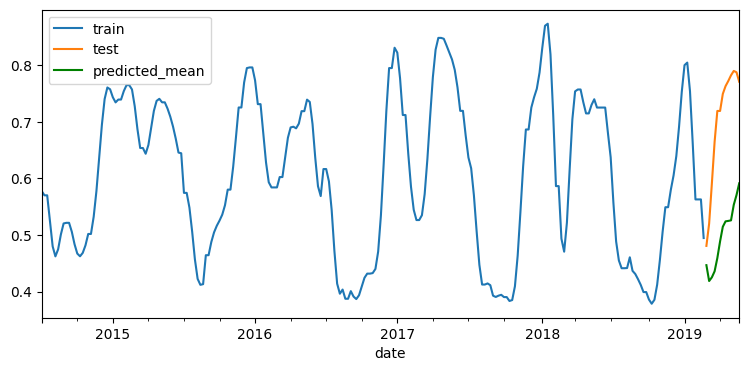

In [9]:
fig, ax=plt.subplots(figsize=(9, 4))
X_train['indices'].plot(ax=ax, label='train')
X_test['indices'].plot(ax=ax, label='test')
forecast.plot(ax=ax, label='predictions', color='green')
ax.legend()

In [10]:
import joblib

joblib.dump(model,'../model/100.h5')

['../model/100.h5']

In [11]:
from cassandra.cluster import Cluster
import uuid

cluster = Cluster(['localhost'])
session = cluster.connect('prediction')
for i in df.iterrows():
    query = "INSERT INTO data_series (data_id, id_municipio, valor_indice, data) VALUES (%s,%s, %s, %s)"
    session.execute(query, (uuid.uuid4(), 100, i[1]['indices'], f'{i[0].year}-{i[0].month}-{i[0].day}'))
session.shutdown()
cluster.shutdown()